In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
# Load MNIST data
transform = transforms.ToTensor()
train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader1 = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
train_loader2 = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)


In [4]:
# Train model
def train_model(model, optimizer, train_loader, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

In [5]:
# Evaluate model loss and accuracy
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(loader), accuracy


In [6]:
# Interpolation between models
def interpolate_models(model1, model2, alpha):
    new_model = SimpleNN()
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    interpolated_state_dict = {}
    
    for key in state_dict1.keys():
        interpolated_state_dict[key] = (1 - alpha) * state_dict1[key] + alpha * state_dict2[key]
    
    new_model.load_state_dict(interpolated_state_dict)
    return new_model

In [7]:
# Train two models
model1 = SimpleNN()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)
train_model(model1, optimizer1, train_loader1)

model2 = SimpleNN()
optimizer2 = optim.Adam(model2.parameters(), lr=1e-2)
train_model(model2, optimizer2, train_loader2)

In [8]:
# Interpolate and evaluate
alphas = np.linspace(-1, 2, 50)
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for alpha in alphas:
    interpolated_model = interpolate_models(model1, model2, alpha)
    
    # Evaluate on both training and test sets
    train_loss, train_accuracy = evaluate_model(interpolated_model, train_loader1)
    test_loss, test_accuracy = evaluate_model(interpolated_model, test_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

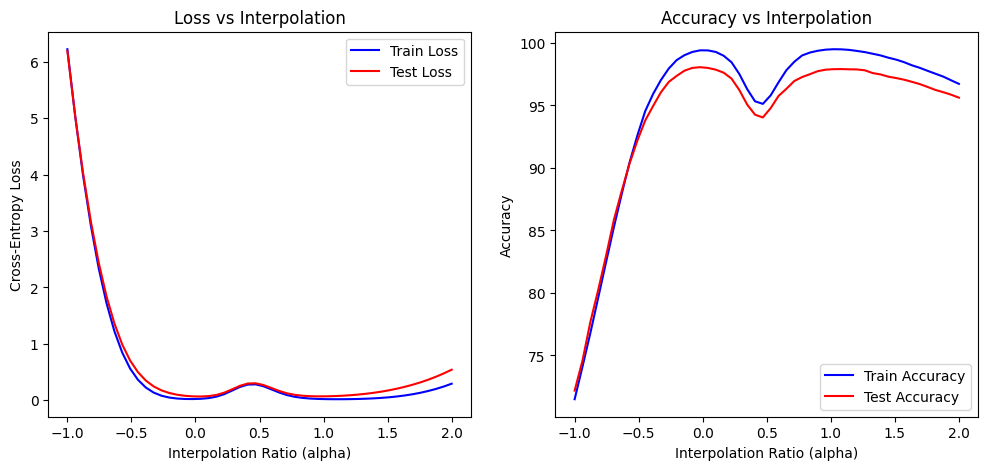

In [9]:
# Results
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(alphas, train_losses, label='Train Loss', color='blue')
plt.plot(alphas, test_losses, label='Test Loss', color='red')
plt.xlabel('Interpolation Ratio (alpha)')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs Interpolation')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(alphas, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(alphas, test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Interpolation Ratio (alpha)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Interpolation')
plt.legend()

plt.show()